In [1]:
import torch
from IPython import display
from d2l import torch as d2l

In [3]:
batch_size = 256 #设置数据迭代器的批量⼤小为256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size) #Fashion-MNIST数据集

In [5]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True) 
b = torch.zeros(num_outputs, requires_grad=True)

In [6]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [7]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 这⾥应⽤了⼴播机制

In [8]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.5168, 0.0541, 0.0722, 0.3136, 0.0433],
         [0.0815, 0.1017, 0.6607, 0.0263, 0.1297]]),
 tensor([1.0000, 1.0000]))

In [9]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [10]:
# 交叉熵损失函数
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y] #索引[0,0]和[1,2]

tensor([0.1000, 0.5000])

In [11]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y]) ##索引[0,0]和[1,2]
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [18]:
def accuracy(y_hat, y): #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) #获取每行最大向量的索引
    cmp = y_hat.type(y.dtype) == y   #做预测索引标签比较
    return float(cmp.type(y.dtype).sum()) #求取正确的标签个数
accuracy(y_hat, y) / len(y)

0.5

In [20]:
# 同样，对于任意数据迭代器data_iter可访问的数据集，我们可以评估在任意模型net的精度
def evaluate_accuracy(net, data_iter): #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel()) # 正确预测数、预测总数
    return metric[0] / metric[1]

In [19]:
# 在上⾯的evaluate_accuracy函数中，我们在Accumulator实例中创建了2个变量，分别⽤于存储正确预测的数量和预测的总数量
class Accumulator: #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [21]:
# 由于我们使⽤随机权重初始化net模型，因此该模型的精度应接近于随机猜测。例如在有10个类别情况下的精度为0.1。
evaluate_accuracy(net, test_iter)

0.1497

In [24]:
def train_epoch_ch3(net, train_iter, loss, updater): #@save
    """训练模型⼀个迭代周期（定义⻅第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使⽤PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()#梯度计算
            updater.step() #自更新
        else:# 使⽤定制的优化器和损失函数(自己实现)
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())#l.sum()损失总和
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [26]:
#我们定义⼀个在动画中绘制数据的实⽤程序类Animator，它能够简化本书其余部分的代码。
class Animator: #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear', yscale='linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使⽤lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [27]:
# 接下来我们实现⼀个训练函数，它会在train_iter访问到的训练数据集上训练⼀个模型net
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save
    """训练模型（定义⻅第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss #断言正确范围，错误则打印
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

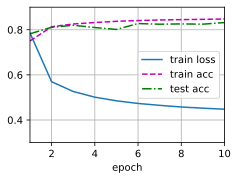

In [28]:
# 作为⼀个从零开始的实现，我们使⽤ 3.2节中定义的小批量随机梯度下降来优化模型的损失函数，设置学习率为0.1。
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)#动态展示训练过程

预测

现在训练已经完成，我们的模型已经准备好对图像进⾏分类预测。给定⼀系列图像，我们将⽐较它们的实际
标签（⽂本输出的第⼀⾏）和模型预测（⽂本输出的第⼆⾏）。

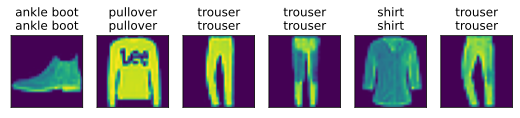

In [29]:
def predict_ch3(net, test_iter, n=6): #@save
    """预测标签（定义⻅第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
predict_ch3(net, test_iter)

⼩结   
• 借助softmax回归，我们可以训练多分类的模型。    
• 训练softmax回归循环模型与训练线性回归模型⾮常相似：先读取数据，再定义模型和损失函数，然后使⽤优化算法训练模型。⼤多数常⻅的深度学习模型都有类似的训练过程。

练习
1. 在本节中，我们直接实现了基于数学定义softmax运算的softmax函数。这可能会导致什么问题？提⽰：尝试计算exp(50)的⼤小。
2. 本节中的函数cross_entropy是根据交叉熵损失函数的定义实现的。它可能有什么问题？提⽰：考虑对数的定义域。
3. 你可以想到什么解决⽅案来解决上述两个问题？
4. 返回概率最⼤的分类标签总是最优解吗？例如，医疗诊断场景下你会这样做吗？
5. 假设我们使⽤softmax回归来预测下⼀个单词，可选取的单词数⽬过多可能会带来哪些问题?

1. 如果网络参数初始化不恰当，或者输入有数值较大的噪音，基于数学定义的softmax运算可能造成溢出，因为分母要计算多个exp 的值求和，解决方法可以参考log_softmax。
2. 提示：考虑对数的值 域。y^中若某行最大的值也接近0的话，loss的值也可能造成溢出，可以参考nllloss和log_softmax一起使用。
3. 参考nllloss和log_softmax一起使用。
4. 返回最大概率标签不总是个好主意，医疗诊断场景也有尽可能避免小概率事件的发生。
5. 词汇量大意味着class的类别很多，这容易带来两个问题。一是造成较大的计算压力，二是所有的单词所得概率容易很接近0，单词 间概率差别不大，很难判断应该输出哪个结果。